Step 1: Import Libraries

In [67]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mtcnn import MTCNN
import torch
import pymesh
from matplotlib.patches import Rectangle
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation
import open3d as o3d
import pyvista as pv



In [68]:
image_path = "images/img4.jpg"

Step 2: Face Alignment and Cropping

In [78]:
def align_and_crop_face(image):
    detector = MTCNN()
    
    faces = detector.detect_faces(image)
    
    if len(faces) == 0:
        return None, None
    
    face = faces[0]
    x, y, w, h = face['box']
    
    aligned_face = image[y:y+h, x:x+w]
    
    padding = 20  
    cropped_face = aligned_face[padding:-padding, padding:-padding] 
    
    return aligned_face, cropped_face

Step 3: Align and Crop

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


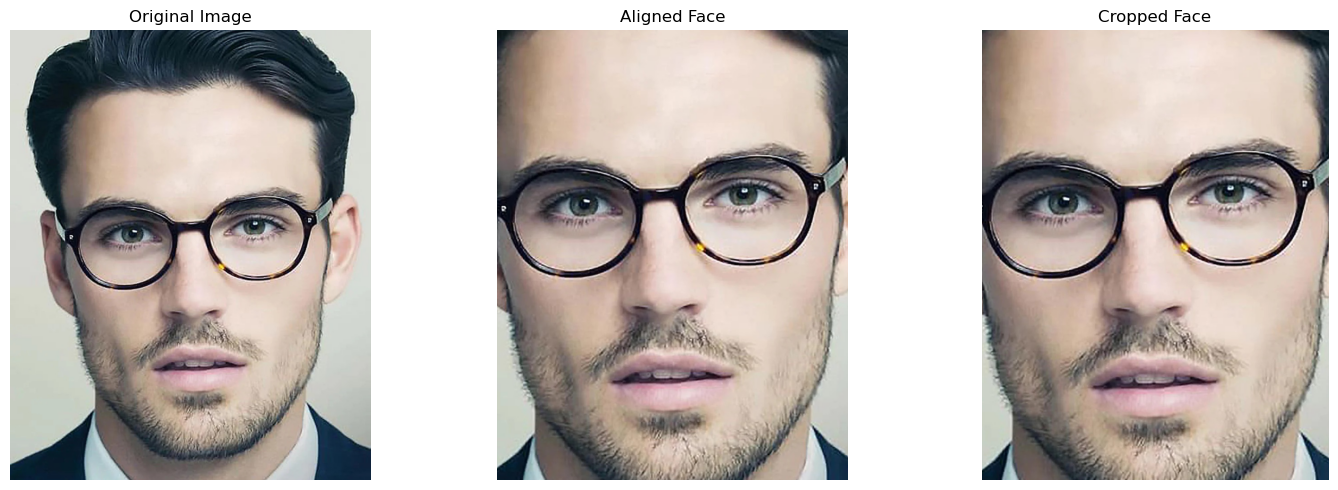

Aligned face saved at: images/aligned_face/aligned_face.jpg
Cropped face saved at: images/cropped_face/cropped_face.jpg


In [70]:
image = plt.imread(image_path)

aligned_face, cropped_face = align_and_crop_face(image)

if aligned_face is not None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(aligned_face)
    axes[1].set_title("Aligned Face")
    axes[1].axis('off')
    
    axes[2].imshow(cropped_face)
    axes[2].set_title("Cropped Face")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    aligned_face_dir = "images/aligned_face"
    cropped_face_dir = "images/cropped_face"
    os.makedirs(aligned_face_dir, exist_ok=True)
    os.makedirs(cropped_face_dir, exist_ok=True)
    
    aligned_face_path = os.path.join(aligned_face_dir, "aligned_face.jpg")
    cropped_face_path = os.path.join(cropped_face_dir, "cropped_face.jpg")
    
    plt.imsave(aligned_face_path, aligned_face)
    plt.imsave(cropped_face_path, cropped_face)
    
    print("Aligned face saved at:", aligned_face_path)
    print("Cropped face saved at:", cropped_face_path)
    
else:
    print("No face detected in the image.")


Step 4: Estimate Depth

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


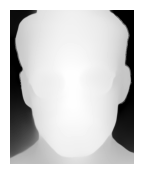

In [71]:
#image_path = "images/aligned_face/aligned_face.jpg"
#image_path = "images/cropped_face/cropped_face.jpg"  
image = Image.open(image_path)

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
image_np = np.array(image)
rgb = image_np



plt.figure(figsize=(2,2))
plt.imshow(depth, cmap='gray')
plt.axis('off')
plt.show()

Step 5: 3D Reconstruction

In [72]:
depth = np.array(depth)
rgb = np.array(image_np)

# Create point cloud from depth map
fx, fy = 625.0, 625.0  # Focal lengths
cx, cy = 319.5, 239.5  # Optical center
depth_scale = 1500.0  # Depth scale
width, height = depth.shape[1], depth.shape[0]

intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(rgb),
    o3d.geometry.Image(depth),
    depth_scale=depth_scale,
    depth_trunc=1000.0,
    convert_rgb_to_intensity=False
)

Step 6: Create and save point cloud 

In [73]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    intrinsic
)

o3d.io.write_point_cloud("3d_head.ply", pcd)

True

Step 7: Plot

/Users/li/anaconda3/envs/tf/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/li/anaconda3/envs/tf/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


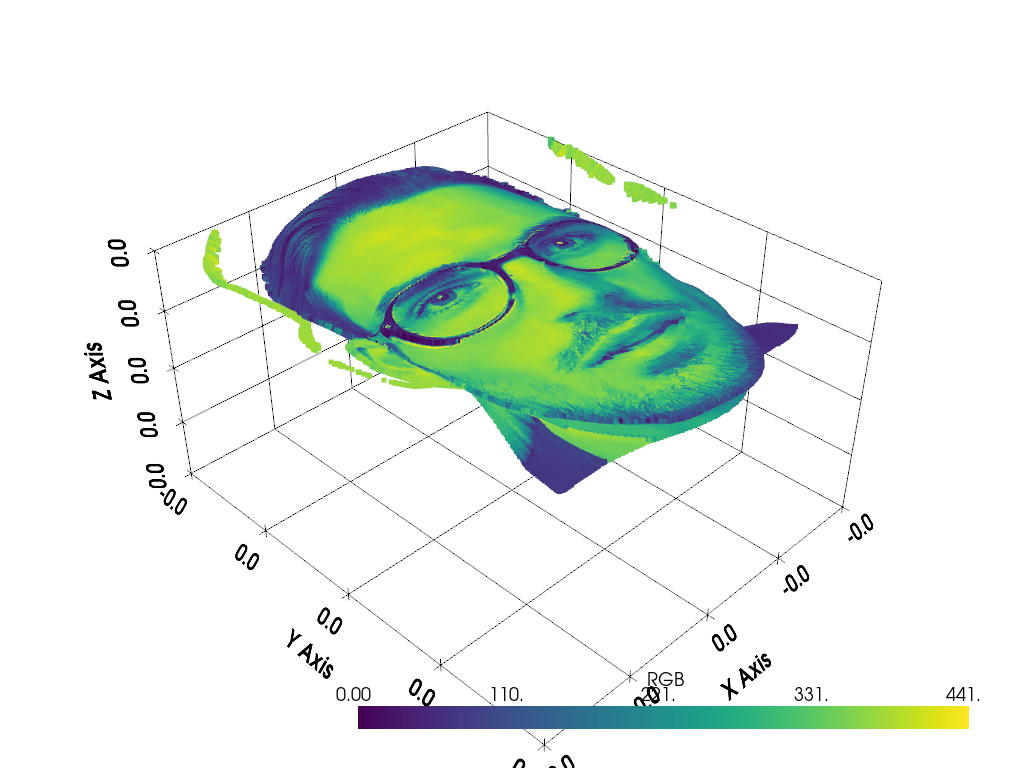

In [74]:
mesh = pv.read("3d_head.ply")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh)
plotter.show_grid(color='black')
plotter.show()

Step 8: View in Open3d

In [75]:
pcd = o3d.io.read_point_cloud("3d_head.ply")
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
